In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow import keras
print("tf version {0} executing eagerly is {1}".format(tf.__version__, tf.executing_eagerly()))

import tensorflow_probability as tfp
print("tfp version {0}".format(tfp.__version__))

TensorFlow 2.x selected.
tf version 2.1.0 executing eagerly is True
tfp version 0.9.0


In [18]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = '/content/drive/My Drive/StoicNetData/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
device_name = tf.test.gpu_device_name()
print("Device name: \"{0}\"".format(device_name))
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

Device name: "/device:GPU:0"
Found GPU at: /device:GPU:0
1 Physical GPUs, 1 Logical GPUs


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import cv2
import sys
import os
import time
import numpy as np
import glob
import PIL
import imageio
import matplotlib.pyplot as plt
from IPython import display

import warnings
warnings.simplefilter('error', UserWarning)
warnings.filterwarnings("error")

In [0]:
tf.random.set_seed(98475651423)

In [0]:
IMG_HEIGHT = 112
IMG_WIDTH = 112

keys_to_features = {
    'image_neutral': tf.io.FixedLenFeature([], tf.string),
    'image_expressive': tf.io.FixedLenFeature([], tf.string),
    'image_other': tf.io.FixedLenFeature([], tf.string)
}

def parser(record):
    parsed = tf.io.parse_single_example(record, keys_to_features)
    
    imageNeutral = tf.io.decode_raw(parsed["image_neutral"], tf.uint8)
    imageExpressive = tf.io.decode_raw(parsed["image_expressive"], tf.uint8)
    imageOther = tf.io.decode_raw(parsed["image_other"], tf.uint8)
    
    imageNeutral = tf.cast(imageNeutral, tf.float32)
    imageExpressive = tf.cast(imageExpressive, tf.float32)
    imageOther = tf.cast(imageOther, tf.float32)
    
    imageNeutral = tf.reshape(imageNeutral, shape=[224,224,1])
    imageExpressive = tf.reshape(imageExpressive, shape=[224,224,1])
    imageOther = tf.reshape(imageOther, shape=[224,224,1])

    imageNeutral = tf.image.resize(imageNeutral, size=[IMG_HEIGHT,IMG_WIDTH])
    imageExpressive = tf.image.resize(imageExpressive, size=[IMG_HEIGHT,IMG_WIDTH])
    imageOther = tf.image.resize(imageOther, size=[IMG_HEIGHT,IMG_WIDTH])

    imageNeutral /= (255/2)
    imageExpressive /= (255/2)
    imageOther /= (255/2)
    imageNeutral -= 1
    imageExpressive -= 1
    imageOther -= 1

    return {"imageNeutral":imageNeutral, "imageExpressive":imageExpressive, "imageOther":imageOther}

In [7]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

DB_PATH = BASE_DIR
raw_train = tf.data.TFRecordDataset(DB_PATH + "train.tfrecords")
raw_test = tf.data.TFRecordDataset(DB_PATH + "test.tfrecords")

raw_val = raw_test.shard(2,0)
raw_test = raw_test.shard(2,1)

parsed_train = raw_train.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_val = raw_val.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
parsed_test = raw_test.map(parser).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print("Train: {0}\nTest: {1}\nValid: {2}".format(parsed_train, parsed_test, parsed_val))

Train: <BatchDataset shapes: {imageNeutral: (None, 112, 112, 1), imageExpressive: (None, 112, 112, 1), imageOther: (None, 112, 112, 1)}, types: {imageNeutral: tf.float32, imageExpressive: tf.float32, imageOther: tf.float32}>
Test: <BatchDataset shapes: {imageNeutral: (None, 112, 112, 1), imageExpressive: (None, 112, 112, 1), imageOther: (None, 112, 112, 1)}, types: {imageNeutral: tf.float32, imageExpressive: tf.float32, imageOther: tf.float32}>
Valid: <BatchDataset shapes: {imageNeutral: (None, 112, 112, 1), imageExpressive: (None, 112, 112, 1), imageOther: (None, 112, 112, 1)}, types: {imageNeutral: tf.float32, imageExpressive: tf.float32, imageOther: tf.float32}>


In [0]:
class TripletLoss(tf.keras.losses.Loss):
    def __init__(self, alpha):
        super(TripletLoss, self).__init__()
        self.alpha = alpha

    def call(self, y_true, y_pred):
        anc = y_pred[0]; pos = y_pred[1]; neg = y_pred[2]
        # distance between the anchor and the positive
        #pos_dist = tf.reduce_sum(tf.square(tf.subtract(anc, pos)), axis=-1)
        pos_dist = tf.reduce_sum(tf.subtract(anc, pos), axis=-1)    
        # distance between the anchor and the negative
        #neg_dist = tf.reduce_sum(tf.square(tf.subtract(anc, neg)), axis=-1)
        neg_dist = tf.reduce_sum(tf.subtract(anc, neg), axis=-1)
        
        return tf.math.maximum(tf.add(tf.subtract(pos_dist, neg_dist), self.alpha), 0.0)


In [0]:
class Recognizer(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Recognizer, self).__init__()
        self.encoder = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
 
            tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=(2,2)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim)
        ], name="encoder")

        self.comparer = tf.keras.models.Sequential(layers=[
            tf.keras.layers.InputLayer(input_shape=(latent_dim)),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ], name="comparer")

    
    @tf.function
    def recognize(self, a, b):
        a_encoding = self.encode(a)
        b_encoding = self.encode(b)

        return self.decide(a_encoding, b_encoding)
    
    @tf.function
    def encode(self, x):
        encoding = self.encoder(x)
        return encoding

    @tf.function
    def decide(self, a_enc, b_enc):
        diffs = tf.abs(a_enc - b_enc)
        prediction = self.comparer(diffs)
        return prediction


latent_dim = 100
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006, beta_1=0.5)
recognizer = Recognizer(latent_dim)

In [0]:
checkpoint_dir = BASE_DIR + 'training_checkpoints/recog_training_1/cp.ckpt'
checkpoint = tf.train.Checkpoint(optimizer=optimizer,recognizer=recognizer)

In [0]:
def plot_loss(ls):
    fig = plt.figure()
    plt.plot(ls, color='r', marker='o')
    plt.title("Loss")
    plt.tight_layout()
    plt.show()

def plot_accuracy(accs):
    fig = plt.figure()
    plt.plot(accs, color='g', marker='o')
    plt.title("Accuracy")
    plt.tight_layout()
    plt.show()


def display_ratings(data, count=0):
    if isinstance(data, dict):
        expressive = tf.convert_to_tensor(data['imageExpressive'], tf.float32)
        neutral = tf.convert_to_tensor(data['imageNeutral'], tf.float32)
        other = tf.convert_to_tensor(data['imageOther'], tf.float32)
    else:
        for image_features in data:
            expressive = image_features['imageExpressive']
            neutral = image_features['imageNeutral']
            other = image_features['imageOther']

    if count <= 0: 
        count = min(8, expressive.shape[0])
    if count > expressive.shape[0]:
        count = expressive.shape[0]

    expressive = expressive[0:count]
    neutral = neutral[0:count]
    other = other[0:count]

    display_ratings_split(count, neutral, expressive, other)

def display_ratings_split(count, neutral, expressive, other):
    pos_ratings = recognizer.recognize(expressive, neutral)
    neg_ratings = recognizer.recognize(expressive, other)
    sample_titles = np.expand_dims(-1*np.ones(count), axis=1)

    ims = np.concatenate((expressive, neutral, other), axis=0)
    ratings = np.concatenate((sample_titles, pos_ratings, neg_ratings), axis=0)
    
    fig, axes = plt.subplots(nrows=3, ncols=count, figsize=(count+2,4))
    for i in range(ims.shape[0]):
        r = i % count
        c = i // count
        if ratings[i,0] >= 0:
            axes[c, r].set_title("{0:.5f}".format(ratings[i,0]))
        axes[c, r].imshow(ims[i, :, :, 0], cmap='gray')
        axes[c, r].set_yticklabels([])
        axes[c, r].xaxis.set_visible(False)
    axes[0,0].set_ylabel("Anchor", size='large')
    axes[1,0].set_ylabel("Positive", size='large')
    axes[2,0].set_ylabel("Negative", size='large')

    fig.tight_layout()
    plt.show()

In [0]:
def compute_loss(rec, x_neutral, x_express, x_other):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    triplet_loss = TripletLoss(tf.convert_to_tensor(0.2, dtype=tf.float32))

    e_neutral = rec.encode(tf.convert_to_tensor(x_neutral, tf.float32))
    e_express = rec.encode(tf.convert_to_tensor(x_express, tf.float32))
    e_other = rec.encode(tf.convert_to_tensor(x_other, tf.float32))

    tl = triplet_loss([], [e_express, e_neutral, e_other])

    pos_preds = rec.decide(e_express, e_neutral)
    neg_preds = rec.decide(e_express, e_other)
    
    pos_labels = tf.ones_like(pos_preds)
    pos_loss = cross_entropy(pos_labels, pos_preds)

    neg_labels = tf.zeros_like(neg_preds)
    neg_loss = cross_entropy(neg_labels, neg_preds)

    return tl + (pos_loss + neg_loss)


def compute_accuracy_keep_fails(rec, data):
    SUCCESS_MARGIN = 0.3
    x_express = tf.convert_to_tensor(data['imageExpressive'], tf.float32)
    x_neutral = tf.convert_to_tensor(data['imageNeutral'], tf.float32)
    x_other = tf.convert_to_tensor(data['imageOther'], tf.float32)

    pos_preds = rec.recognize(x_express, x_neutral).numpy()
    neg_preds = rec.recognize(x_express, x_other).numpy()

    good_pos = np.squeeze(np.greater(pos_preds, 0.5))
    good_neg = np.squeeze(np.less(neg_preds, 0.5))
    good_dist = np.squeeze(np.greater(pos_preds, neg_preds + SUCCESS_MARGIN))
    good = np.logical_and(np.logical_and(good_pos, good_neg), good_dist)
    correct = np.count_nonzero(good)
    
    if correct < pos_preds.shape[0]:
        fails = {
            'imageExpressive': tf.convert_to_tensor(x_express[good == 0], tf.float32),
            'imageNeutral': tf.convert_to_tensor(x_neutral[good == 0], tf.float32),
            'imageOther': tf.convert_to_tensor(x_other[good == 0], tf.float32)
        }
    else:
        fails = {
            'imageExpressive': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
            'imageNeutral': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
            'imageOther': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32)
        }
    
    return correct, pos_preds.shape[0], fails

def update_fails(failures, new_failures):
    return {
        'imageExpressive': tf.concat((failures['imageExpressive'], new_failures['imageExpressive']), axis=0),
        'imageNeutral': tf.concat((failures['imageNeutral'], new_failures['imageNeutral']), axis=0),
        'imageOther': tf.concat((failures['imageOther'], new_failures['imageOther']), axis=0),
    }

Accuracy 0.0 (3212 mistakes)


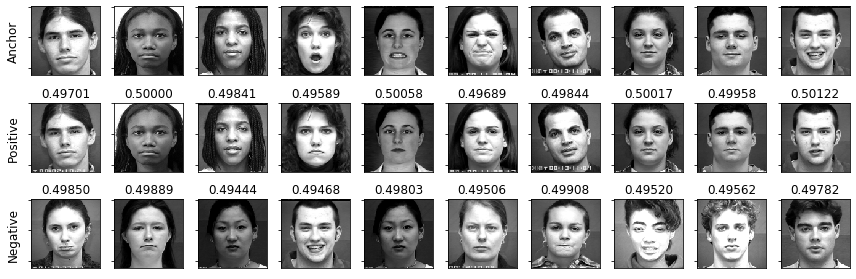

In [13]:
failures = {
    'imageExpressive': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
    'imageNeutral': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
    'imageOther': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32)
}
total_correct = total_samples = 0
for image_features in parsed_test:
    a, t, fs = compute_accuracy_keep_fails(recognizer, image_features)
    failures = update_fails(failures, fs)
    total_correct += a
    total_samples += t
acc = total_correct / total_samples
mistakes = total_samples - total_correct
print('Accuracy {0} ({1} mistakes)'.format(
    acc, mistakes))
display_ratings(failures)

Epoch 49, Loss 0.13650846481323242, Accuracy 0.9950186799501868 (16 mistakes), time elapsed 32.7


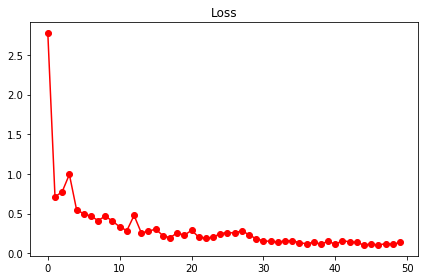

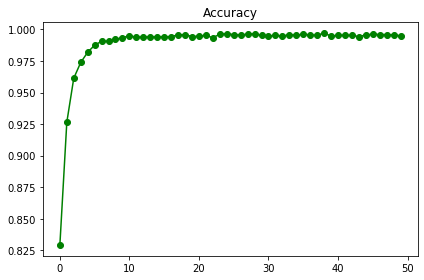

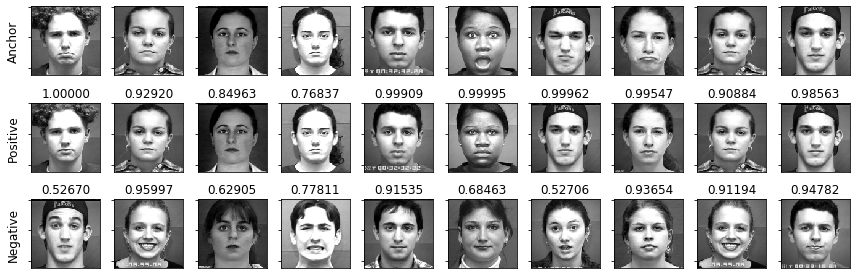

In [14]:
epochs = 50

losses = []
accurs = []
start_time = end_time = 0

for epoch in range(0, epochs):
    # Train
    print("\nTraining", end="")
    start_time = time.time()
    batchCounter = 0
    failures = {
        'imageExpressive': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
        'imageNeutral': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
        'imageOther': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32)
    }
    for image_features in parsed_train:
        neutral_raw = image_features['imageNeutral']
        assert not np.any(np.isnan(neutral_raw))
        expressive_raw = image_features['imageExpressive']
        assert not np.any(np.isnan(expressive_raw))
        other_raw = image_features['imageOther']
        assert not np.any(np.isnan(other_raw))

        with tf.GradientTape() as tape:
            loss = compute_loss(recognizer, neutral_raw, expressive_raw, other_raw)
        
        gradients = tape.gradient(loss, recognizer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, recognizer.trainable_variables))

        a, t, fs = compute_accuracy_keep_fails(recognizer, image_features)
        failures = update_fails(failures, fs)

        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")


    # Do a failure bonus round
    if a == t:
        print("\nPerfect Training Accuracy")
    else:
        print("\nTraining for {0} worst samples".format(failures['imageNeutral'].shape[0]), end="")
        fails_dataset = tf.data.Dataset.from_tensor_slices(failures).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        batchCounter = 0
        for image_features in fails_dataset:
            with tf.GradientTape() as tape:
                loss = compute_loss(recognizer,
                                    image_features['imageNeutral'],
                                    image_features['imageExpressive'],
                                    image_features['imageOther'])
            gradients = tape.gradient(loss, recognizer.trainable_variables)
            optimizer.apply_gradients(zip(gradients, recognizer.trainable_variables))
            batchCounter += 1
            if batchCounter % 10 == 0:
                print(".", end="")
    end_time = time.time()


    # Test
    print("\nTesting", end="")
    loss_mean = tf.keras.metrics.Mean()
    total_correct = total_samples = 0
    failures = {
        'imageExpressive': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
        'imageNeutral': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32),
        'imageOther': tf.convert_to_tensor(np.array([]).reshape(0,112,112,1), tf.float32)
    }
    for image_features in parsed_test:
        l = compute_loss(recognizer,
                         image_features['imageNeutral'],
                         image_features['imageExpressive'],
                         image_features['imageOther'])
        loss_mean(l)
        a, t, fs = compute_accuracy_keep_fails(recognizer, image_features)
        failures = update_fails(failures, fs)
        total_correct += a
        total_samples += t
        batchCounter += 1
        if batchCounter % 10 == 0:
            print(".", end="")
    acc = total_correct / total_samples
    mistakes = total_samples - total_correct
    l = loss_mean.result()
    losses = losses + [l]
    accurs = accurs + [acc]


    display.clear_output(wait=False)
    print('Epoch {0}, Loss {1}, Accuracy {2} ({3} mistakes), time elapsed {4:.1f}'.format(
        epoch, losses[-1], accurs[-1], mistakes, end_time - start_time))
    plot_loss(losses)
    plot_accuracy(accurs)
    display_ratings(failures)
    #display_ratings(parsed_test.take(1))

    if acc >= 1.0:
        print("DONE TRAINING")
        break

In [28]:
# Save the model!
!mkdir -p "{BASE_DIR}/saved_model"
recognizer.encoder.save(BASE_DIR + 'saved_model/recognizerEncoder.h5')
recognizer.comparer.save(BASE_DIR + 'saved_model/recognizerComparer.h5')
recognizer.comparer.save(BASE_DIR + 'saved_model/recognizer')
recognizer.save_weights(BASE_DIR + 'saved_model/recognizerWeights')

INFO:tensorflow:Assets written to: /content/drive/My Drive/StoicNetData/saved_model/recognizer/assets


In [29]:
# Make sure everything saved properly
new_model = Recognizer(latent_dim)
new_model.load_weights(BASE_DIR + 'saved_model/recognizerWeights')
total_correct = 0
total_samples = 0
for image_features in parsed_test:
    a, t, _ = compute_accuracy_keep_fails(new_model, image_features)
    total_correct += a
    total_samples += t
acc = total_correct / total_samples
print("Accuracy: " + str(acc))

Accuracy: 0.9950186799501868
